In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tables
import pandas as pd
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
import matminer.datasets as md
from matminer.datasets import load_dataset
import ase
from ase import Atoms
from ase.io import read, write, iread
from rascal.representations import SphericalInvariants as SOAP
from itertools import islice


In [2]:
"""TO FILE MP_db.zip for any necessity - MP_dataset.zip has all entries, also the NaN ones and is much longer"""

# df = load_dataset("mp_all_20181018")
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

# """Converting pymatgen core structure t ASE atoms obkect for SOAP vectors calculation"""

# def get_atoms(structure, **kwargs):
#         """
#         Returns ASE Atoms object from pymatgen structure or molecule.
#         Args:
#             structure: pymatgen.core.structure.Structure or pymatgen.core.structure.Molecule
#             **kwargs: other keyword args to pass into the ASE Atoms constructor
#         Returns:
#             ASE Atoms object
#         """
#         symbols = [str(site.specie.symbol) for site in structure]
#         positions = [site.coords for site in structure]
#         if hasattr(structure, "lattice"):
#             cell = structure.lattice.matrix
#             pbc = True
#         else:
#             cell = None
#             pbc = None
#         return Atoms(symbols=symbols, positions=positions, pbc=pbc, cell=cell, **kwargs)
    
# """Creating 'MP.xyz' file with MP data to use every time it is needed"""
    
# ase_frames=[]
# for i in df['initial structure']:
#     frame=get_atoms(i)
#     frame.wrap(eps=1e-10)
#     print(type(frame))
#     ase_frames.append(frame)
    
# xyz=ase.io.write('MP.xyz', ase_frames)
    
# # compression_opts = dict(method='zip',

# #                         archive_name='MP_db.csv')  

# # df.to_csv('MP_db.zip', index=False,

# #           compression=compression_opts)  

# # # df.to_csv('MP_dataset.csv')
# # # df.to_hdf('./MP.h5', 'data')
# # # df.to_pickle('MPdf.df')


NameError: name 'Atoms' is not defined

In [2]:
"""The file has been created in zip format, reading it"""
zf = zipfile.ZipFile('./MP_db.zip') 
df_csv = pd.read_csv(zf.open('MP_db.csv'), usecols=['e_hull','gap pbe', 'mu_b','structure', 'elastic anisotropy','bulk modulus', 'shear modulus', 'e_form'])

formE=df_csv['e_form']

"""Counting number of atoms from string"""   

def natoms(string):
    for item in string:
        if string[(string.find('Sites'))+8] == ')':
            n=(string.find('Sites'))+7
            return int(string[n])
        else:
            n1=(string.find('Sites'))+7
            n2=(string.find('Sites'))+8
            return int(string[n1]+string[n2])
        
natoms_list=[]
for i in range(len(df_csv)):
    natoms_list.append(natoms(df_csv['structure'][i]))
    
df_csv['number atoms'] = natoms_list
    
print(len(formE), len(natoms_list))

7676 7676


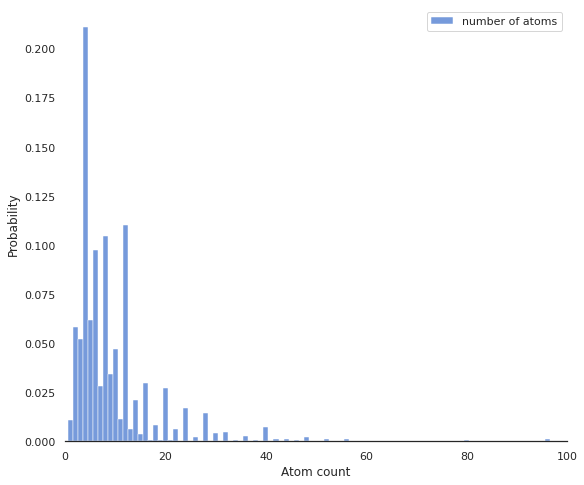

In [3]:
"""Plotting number of atoms in unit cell"""

sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True)
sns.histplot(data=natoms_list, stat="probability", color='b', discrete=True, label='number of atoms')
ax.set_xlabel('Atom count')
plt.legend()
plt.xlim(0,100)
# plt.savefig('MP_natom_occ.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

In [7]:
magic=[None] * len(df_csv)
for i in range(len(df_csv)):
    if df_csv['number atoms'][i]%4==0:
        magic[i]=1
    else:
        magic[i]=0
len(magic)
df_csv['magic?']=magic

In [8]:
df_csv.head()

,e_hull,gap pbe,mu_b,elastic anisotropy,bulk modulus,shear modulus,structure,e_form,number atoms,magic?
0,0.003319,0.0000,2.700000e-05,1.044699,33.154748,4.904836,Full Formula (In1)\nReduced Formula: In\nabc ...,0.003319,1,0
1,0.039182,0.0000,-1.360000e-05,-11.326659,35.636106,1.830272,Full Formula (Mg1)\nReduced Formula: Mg\nabc ...,0.039182,1,0
2,0.108143,0.0000,1.000000e-07,8.030000,124.000000,84.000000,Full Formula (Be4)\nReduced Formula: Be\nabc ...,0.108143,4,1
3,0.071216,0.0000,-2.050000e-05,0.881277,101.242732,44.836516,Full Formula (Hf1)\nReduced Formula: Hf\nabc ...,0.071216,1,0
4,3.509988,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,Full Formula (P1)\nReduced Formula: P\nabc :...,3.509988,1,0


In [9]:
# stop=120
ase_fra=ase.io.read('MP.xyz', index='::25')
for frame in ase_fra:
    frame.wrap(eps=1e-10)
print(len(ase_fra))
# ase_fr=ase.io.iread('MP.xyz')

soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

# soap_rep = soap.transform(islice(ase_fr, stop))
soap_rep = soap.transform(ase_fra)
X_raw = soap_rep.get_features(soap)
num_features = X_raw.shape[1]
print(soap)

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=25)
X_ipca = ipca.fit_transform(X_raw)

print(X_ipca)



308
[[-0.15103582 -0.08992711]
 [-0.14328877 -0.07737615]
 [-0.14457826 -0.08812814]
 ...
 [-0.26298193  0.38526936]
 [-0.26298193  0.38526936]
 [-0.26298193  0.38526936]]


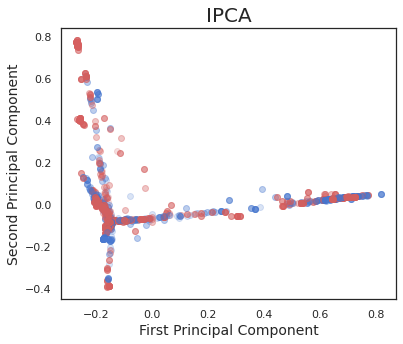

In [11]:
ig,ax=plt.subplots(figsize=(6,5))
start=0
for frame in ase_fra:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_ipca[start:int(start+natoms), 0], X_ipca[start:int(start+natoms), 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_ipca[start:int(start+natoms) , 0], X_ipca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("IPCA",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.savefig('IPCA_MP.png', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()


In [64]:
# original_headers = list(df_csv.columns.values)
# df_csv = df_csv._get_numeric_data()
# numeric_headers = list(df_csv.columns.values)
# df_array = df_csv.values
# print((df_array[101,7]))

red_df=df_csv[::25]
red_df = red_df._get_numeric_data()
red_df.reset_index(drop=True, inplace=True)
red_df['SOAP']=[None]*len(red_df)

red_df.head()
# # print(type(X_raw[0]))

pca_array=X_raw
start=0
print(len(ase_fra), len(red_df))
for i in range(len(ase_fra)):
    natoms=(len(ase_fra[i]))
    red_df['SOAP'][i]=np.asarray(pca_array[start:int(start+natoms)])
# #     print(type((i)))
# #     print(start, natoms)
# #     if natoms%4==0:
#     np.append(pca_array[start:int(start+natoms)], [red_df['e_form'][i]]) #red_df['mu_b'][i])
# #         ax.scatter(X_ipca[start:int(start+natoms), 0], X_ipca[start:int(start+natoms), 1],c='r', alpha=0.2)
# #     else:
# #         ax.scatter(X_ipca[start:int(start+natoms) , 0], X_ipca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
#     print(type(start))

(red_df['SOAP'][23].shape)

308 308


(3, 133560)

In [65]:
df_array = red_df.values
scaler=StandardScaler()#instantiate
scaler.fit(df_array) # compute the mean and standard which will be used in the next command
X_scaled=scaler.transform(df_array)# fit and transform can be applied together and I leave that for simple exercise 
pca=PCA(n_components=2) 
pca.fit(X_scaled)
X_pca = pca.fit_transform(X_scaled)
# ipca = IncrementalPCA(n_components=n_components, batch_size=10)


ValueError: setting an array element with a sequence.

In [25]:
len(X_pca[:,1])

7676

[0. 0. 1. ... 0. 1. 0.]
0.0
1.0


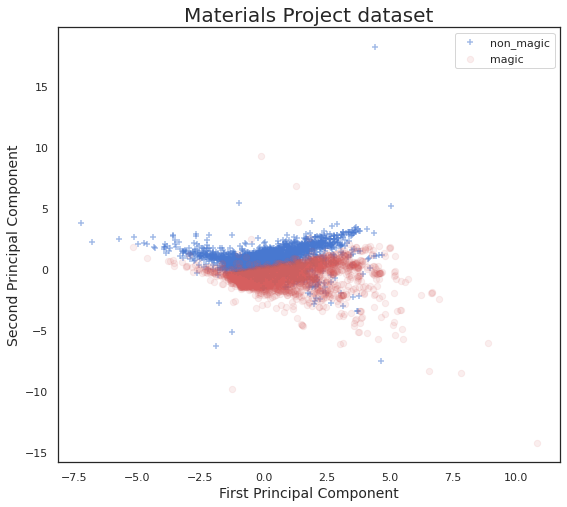

In [38]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=np.asarray(df_array[:,8])
print(labels)
cdict={0:'b',1:'r'}
labl={0:'non_magic',1:'magic'}
marker={0:'+',1:'o'}
alpha={0:.5, 1:.1}

fig,ax=plt.subplots(figsize=(9,8))

for l in np.unique(labels):
    print(l)
    
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])# for loop ends
         
plt.title("Materials Project dataset",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.savefig('PCA_MP', bbox_inches= 'tight', dpi=700 )
plt.show()# please check the scatter plot of the remaining component and you will understand the difference

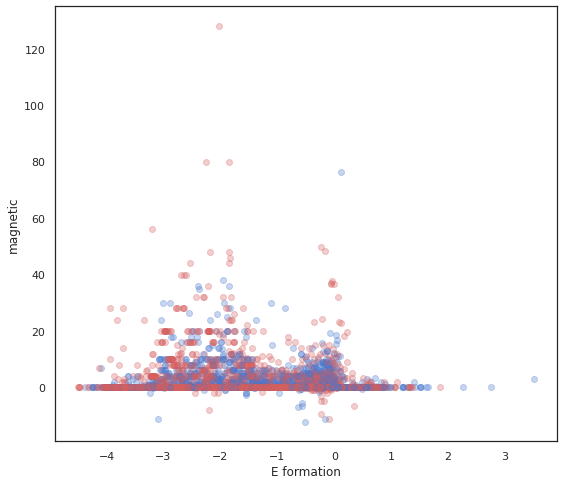

In [23]:
# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)
# clean_df=clean_dataset(df)

plt.figure(figsize=(9, 8))  
for i in range(7675):
    if int(df_array[i,8])==1:
        plt.scatter(df_array[i,6], df_array[i,2], color='r', alpha=0.3)
    else:
        plt.scatter(df_array[i,6], df_array[i,2], color='b', alpha=0.3)

plt.xlabel('E formation',fontsize=12)
plt.ylabel('magnetic',fontsize=12)
plt.savefig('scatterMP.png', bbox_inches= 'tight', dpi=400 )
plt.show()